In [ ]:
# Loading libraries

suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(monocle3))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))

set.seed(42)

In [26]:
# Assigning the RDS file direction

pbmc_Seurat_RDS_direction <- "/home/arsham79/scratch/nsclc/results/pbmc_cell_type_annotated.rds"
cds_monocole_RDS_direction <-  "/home/arsham79/scratch/nsclc/results/monocole3_cds_objectd_trained.rds"

In [27]:
# Reading the Seurat object

pbmc <- readRDS(pbmc_Seurat_RDS_direction)

In [28]:
new_tumor_stage <- data.table(new_tumor_stage = c("1. Normal", "2. 0", "3. I", "4. II and III", "4. II and III", "5. IV"),
                             tumor_stage = c("N", "0", "I", "II", "III", "IV"))

old_tumor_stage <- data.table(tumor_stage = pbmc@meta.data$tumor_stage)
new_tumor_stage <- merge(old_tumor_stage, new_tumor_stage, by = "tumor_stage", sort = FALSE)
pbmc@meta.data$new_tumor_stage <- new_tumor_stage$new_tumor_stage

In [29]:
# Obtaining the normalized count

cnt <- GetAssayData(pbmc@assays$RNA_test)

# Creating custome metadata

meta <- data.table(cell.type = pbmc@active.ident,
                  cell_bar = names(pbmc@active.ident),
                  stage = pbmc@meta.data$new_tumor_stage)

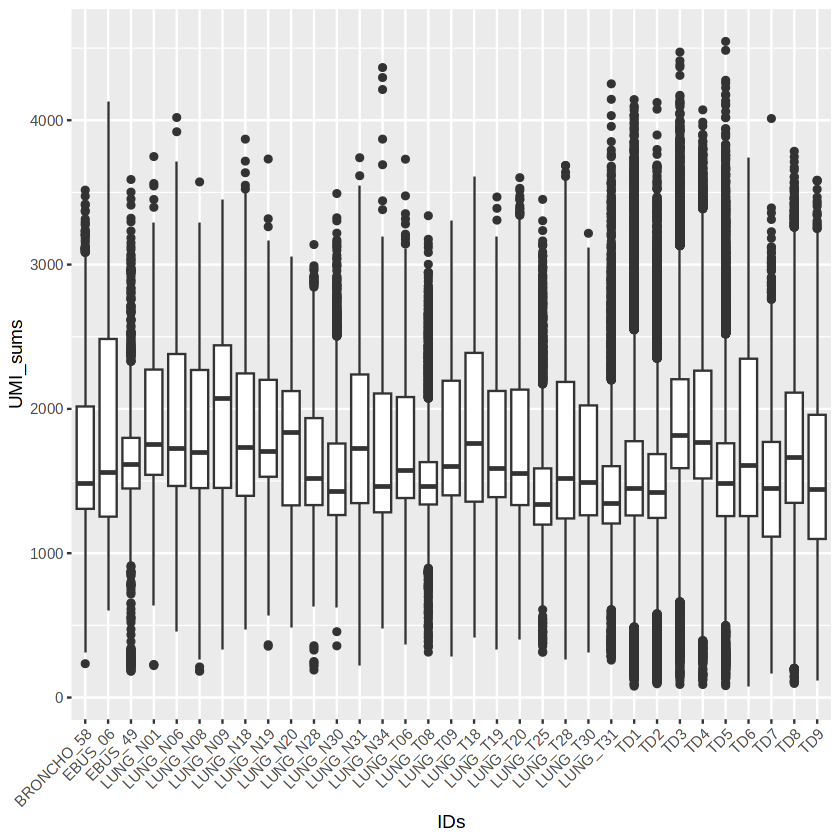

In [30]:
# Testing the gene expression amounts

test <- data.table(IDs = sub("^.*?_(.*$)", "\\1",colnames(cnt)),
                   UMI_sums = colSums(cnt))
# Plotting the boxplot

ggplot(test, aes(x = IDs, y = UMI_sums)) + geom_boxplot() + theme(axis.text.x = element_text(hjust = 1, angle = 45))

## __Lung cells__
#### first, we want to assess the significant genes within lung cluster cell types
This cluster contains five cell types which are alveolar type 1 and 2 cells, club cells, ciliated cells and lastly more importantly alveolar type 2 like cells.

In [32]:
# Creating the desired cell types vector

target_cell_types <- c("AT type II like cells", "Club cells")  # we put "AT type I", "Ciliated cells", and "AT type II" on hold because we could not capture any significant changes.

# Reading the targeted genes within module 6 from monocole 3

target_genes_dt <- fread("../../results/targeted_genes_monocole3_lung_cells.txt", header = FALSE)
target_genes <- target_genes_dt$V1

# Obtaining the barcodes and metadata corespond to the cell types we filtered

target_barcodes <- meta[meta$cell.type %in% target_cell_types, cell_bar]
target_meta <- meta[meta$cell.type %in% target_cell_types, ]

# Filtering the normalized count with targeted barcodes and genes

cnt_targeted <- cnt[target_genes,target_barcodes]

In [36]:
targeted_meta <- target_meta %>% 
                 group_by(cell.type, stage) %>% 
                 mutate(group_ID = cur_group_id()) %>% 
                 ungroup()

targeted_meta <- as.data.table(targeted_meta)

In [37]:
num_rows <- length(target_genes)
num_cols <- max(targeted_meta$group_ID)

Lung_Heatmap_Df <- data.frame(matrix(NA, nrow = num_rows, ncol = num_cols))

rownames(Lung_Heatmap_Df) <- rownames(cnt_targeted)

In [38]:
Lung_Heatmap_Df_colnames <- c()

for(i in 1:max(targeted_meta$group_ID)){
    
    Barcode <- targeted_meta[targeted_meta$group_ID == i, ][, cell_bar]
    Cell_Type <- unique(targeted_meta[targeted_meta$group_ID == i, ][, cell.type])
    Stage <- unique(targeted_meta[targeted_meta$group_ID == i, ][, stage])
    
    temp_cnt <- cnt_targeted[,Barcode]
    row_sums_temp_cnt <- Matrix::rowSums(temp_cnt)
    
    
    Lung_Heatmap_Df[,i] <- row_sums_temp_cnt
    
    temp_colname <- paste0(Cell_Type, "_", Stage , "_")
    Lung_Heatmap_Df_colnames <- c(Lung_Heatmap_Df_colnames, temp_colname)
  
}

colnames(Lung_Heatmap_Df) <- Lung_Heatmap_Df_colnames

In [39]:
options(warn = -1)

suppressMessages(Lung_Heatmap_Df_Melted <- melt(Lung_Heatmap_Df))
Lung_Heatmap_Df_Melted[,3] <- rep(rownames(Lung_Heatmap_Df), ncol(Lung_Heatmap_Df))


Lung_Heatmap_Df_Melted[,4] <- sub("(.*)_(.*)_$", "\\1", Lung_Heatmap_Df_Melted$variable)
Lung_Heatmap_Df_Melted[,5] <- sub("(.*)_(.*)_$", "\\2", Lung_Heatmap_Df_Melted$variable)

Lung_Heatmap_Df_Melted <- Lung_Heatmap_Df_Melted[,-1]
colnames(Lung_Heatmap_Df_Melted) <- c("expr_sum", "gene_name", "cell_type", "stage")

options(warn = 1)

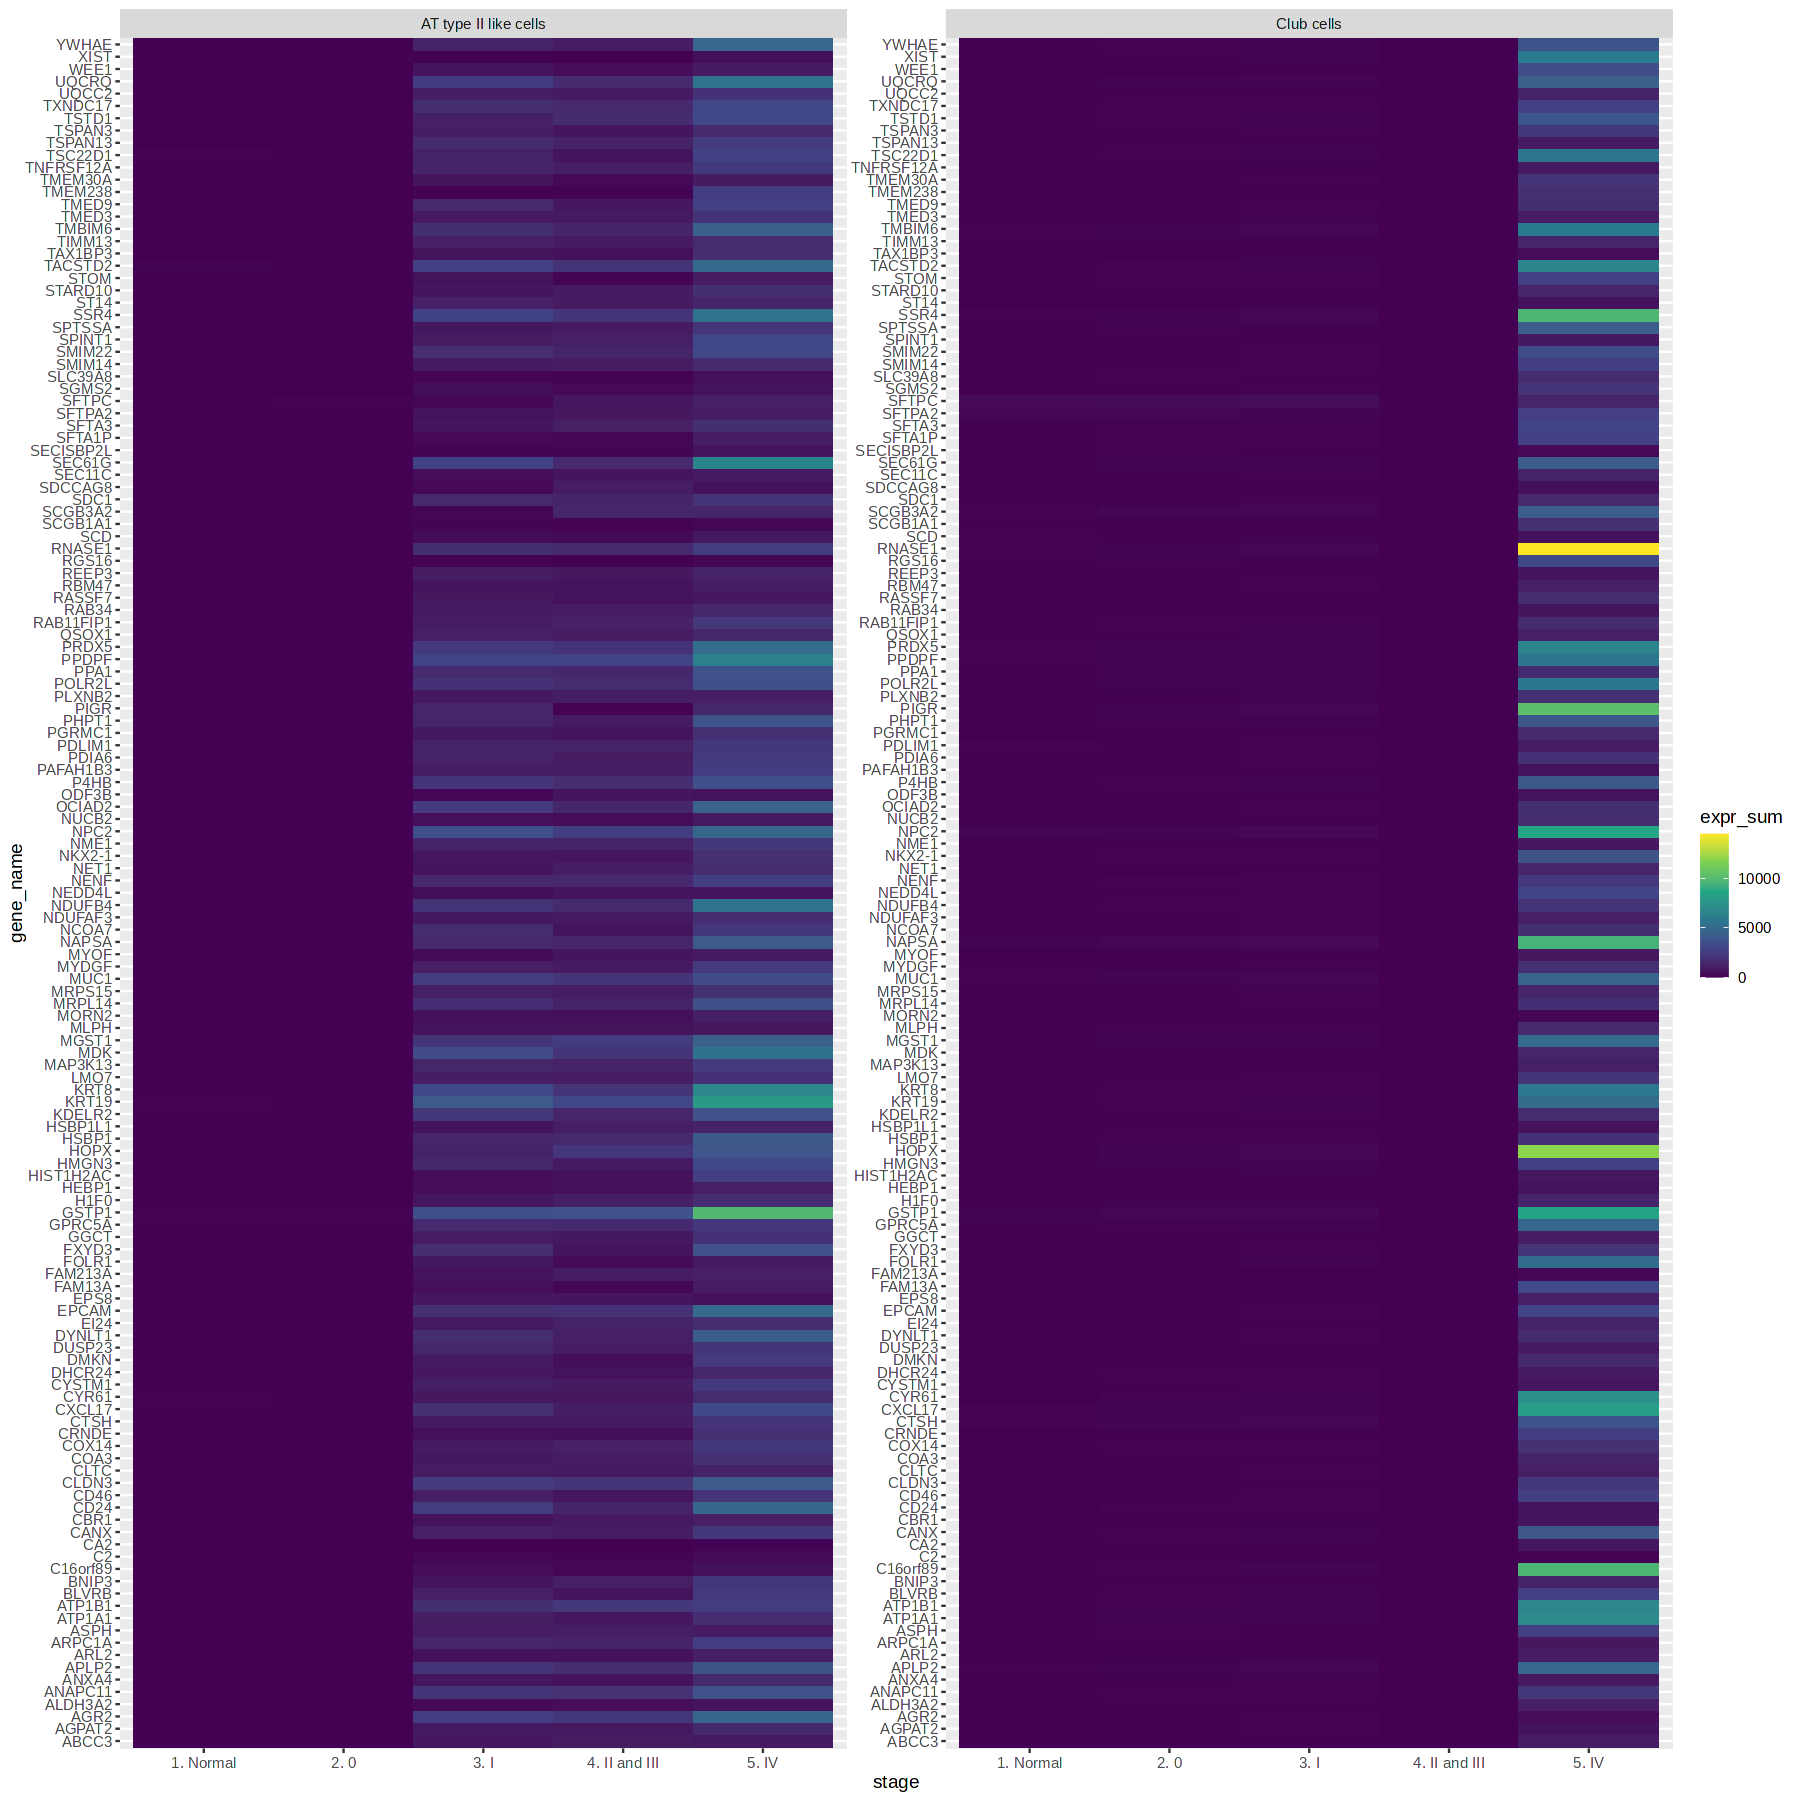

In [40]:
options(repr.plot.width=15, repr.plot.height=15)

ggplot(Lung_Heatmap_Df_Melted) + 
        geom_bin2d(aes(x = stage, y = gene_name, fill = expr_sum)) +
        facet_wrap(~cell_type, scales = "free") +
        scale_fill_viridis_c()

## __Immune cells__
#### them, we want to assess the significant genes within immune cells clusters
This cluster contains three main cell types which are T cells, B cells, and, NK cells.

In [41]:
# Creating the desired cell types vector

target_cell_types <- c("T cells(CD4)", "T cells(CD8)", "B cells", "NK cells")

# Reading the targeted genes within module 6 from monocole 3

target_genes_dt <- fread("../../results/targeted_genes_monocole3_immune_cells.txt", header = FALSE)
target_genes <- target_genes_dt$V1

# Obtaining the barcodes and metadata corespond to the cell types we filtered

target_barcodes <- meta[meta$cell.type %in% target_cell_types, cell_bar]
target_meta <- meta[meta$cell.type %in% target_cell_types, ]

# Filtering the normalized count with targeted barcodes and genes

cnt_targeted <- cnt[target_genes,target_barcodes]

In [42]:
targeted_meta <- target_meta %>% 
                 group_by(cell.type, stage) %>% 
                 mutate(group_ID = cur_group_id()) %>% 
                 ungroup()

targeted_meta <- as.data.table(targeted_meta)

In [43]:
num_rows <- length(target_genes)
num_cols <- max(targeted_meta$group_ID)

Imm_Heatmap_Df <- data.frame(matrix(NA, nrow = num_rows, ncol = num_cols))

rownames(Imm_Heatmap_Df) <- rownames(cnt_targeted)

In [44]:
Imm_Heatmap_Df_colnames <- c()

for(i in 1:max(targeted_meta$group_ID)){
    
    Barcode <- targeted_meta[targeted_meta$group_ID == i, ][, cell_bar]
    Cell_Type <- unique(targeted_meta[targeted_meta$group_ID == i, ][, cell.type])
    Stage <- unique(targeted_meta[targeted_meta$group_ID == i, ][, stage])
    
    temp_cnt <- cnt_targeted[,Barcode]
    row_sums_temp_cnt <- Matrix::rowSums(temp_cnt)
    
    
    Imm_Heatmap_Df[,i] <- row_sums_temp_cnt
    
    temp_colname <- paste0(Cell_Type, "_", Stage , "_")
    Imm_Heatmap_Df_colnames <- c(Imm_Heatmap_Df_colnames, temp_colname)
  
}

colnames(Imm_Heatmap_Df) <- Imm_Heatmap_Df_colnames

In [45]:
options(warn = -1)

suppressMessages(Imm_Heatmap_Df_Melted <- melt(Imm_Heatmap_Df))
Imm_Heatmap_Df_Melted[,3] <- rep(rownames(Imm_Heatmap_Df), ncol(Imm_Heatmap_Df))


Imm_Heatmap_Df_Melted[,4] <- sub("(.*)_(.*)_$", "\\1", Imm_Heatmap_Df_Melted$variable)
Imm_Heatmap_Df_Melted[,5] <- sub("(.*)_(.*)_$", "\\2", Imm_Heatmap_Df_Melted$variable)

Imm_Heatmap_Df_Melted <- Imm_Heatmap_Df_Melted[,-1]
colnames(Imm_Heatmap_Df_Melted) <- c("expr_sum", "gene_name", "cell_type", "stage")

options(warn = 1)

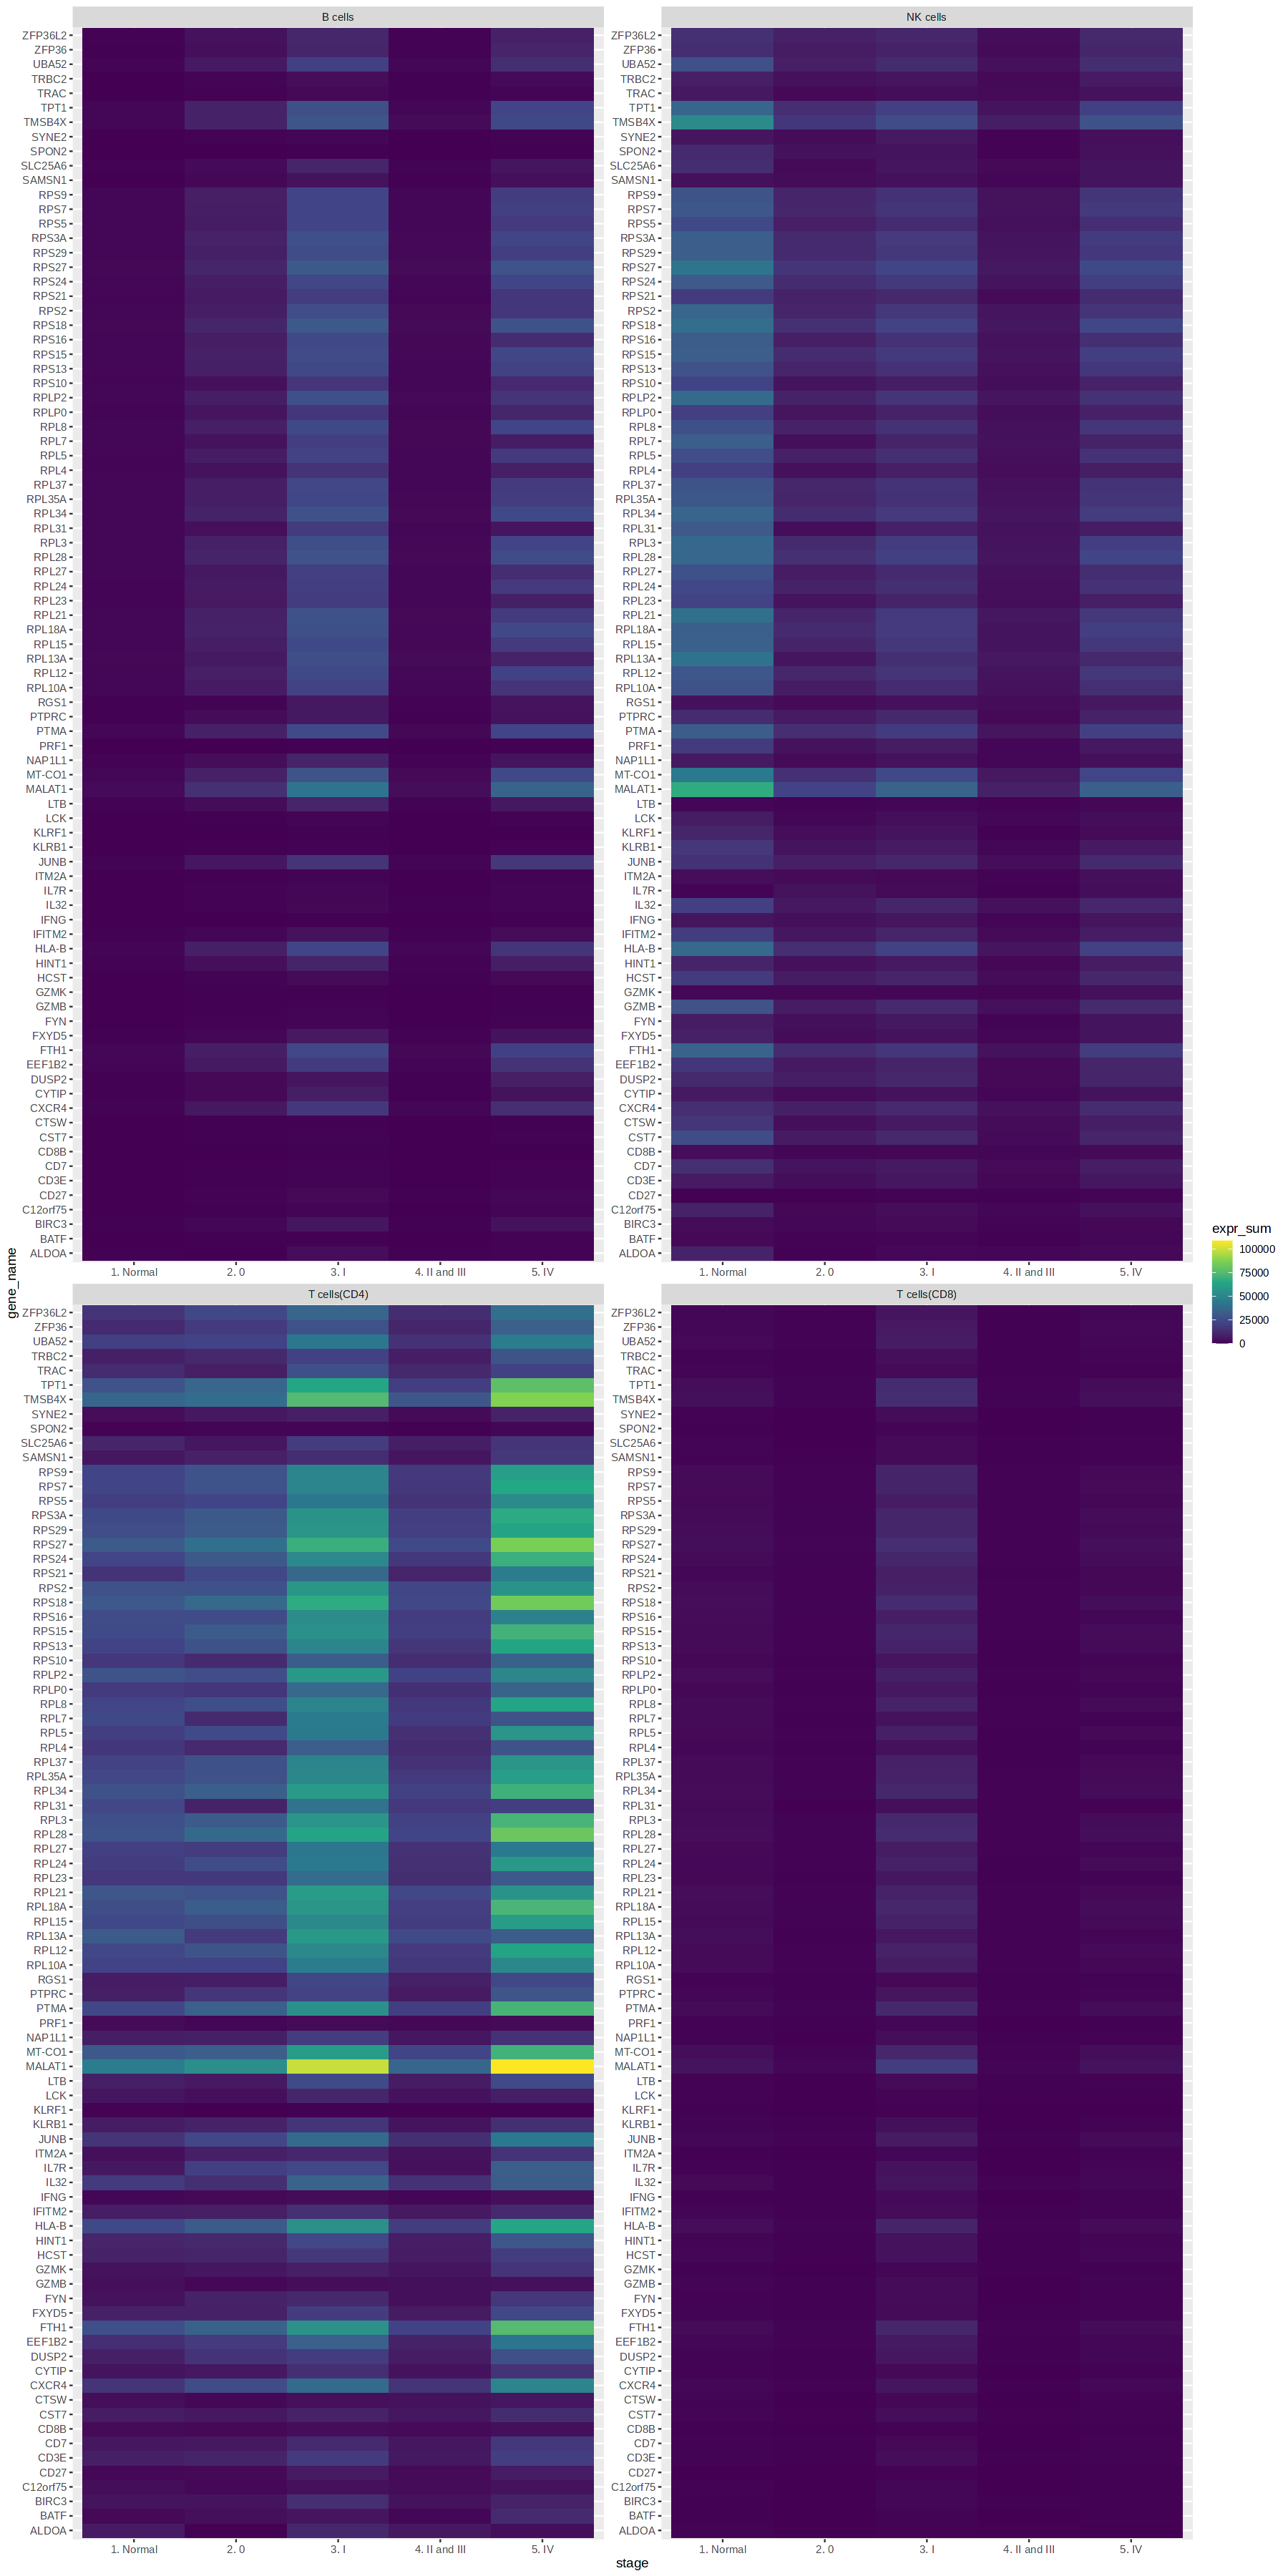

In [46]:
options(repr.plot.width=15, repr.plot.height=30)

ggplot(Imm_Heatmap_Df_Melted) + 
        geom_bin2d(aes(x = stage, y = gene_name, fill = expr_sum)) +
        facet_wrap(~cell_type, scales = "free") +
        scale_fill_viridis_c()

In [149]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: FlexiBLAS IMKL;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] RColorBrewer_1.1-3          gridExtra_2.3              
 [3] repr_1.1.6.9000             lubridate_1.9.3            
 [5] forcats_1.0.0               stringr_1.5.1              
 [7] dplyr_1.1.4                 purrr_1.0.2                
 [9] readr_2.